In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns


C:\Users\roger\AppData\Local\Temp\ipykernel_21300\1513174540.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
import pandas as pd
import numpy as np

# Correct URL for Wine Quality (Red) dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

# Read the data with proper delimiter
data = pd.read_csv(url, sep=';')

# Display the cleaned data
print(data.head())
print("\nShape of dataset:", data.shape)


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [3]:
import numpy as np
import pandas as pd

# Assume 'data' is your preloaded DataFrame
# Example: data = pd.read_csv("winequality-red.csv", sep=';')

# Set seed for reproducibility
np.random.seed(42)

# Choose % of cells to make NaN
nan_percent = 0.05
total_cells = data.size
num_nans = int(total_cells * nan_percent)

# Randomly choose cells
row_indices = np.random.randint(0, data.shape[0], num_nans)
col_indices = np.random.randint(0, data.shape[1], num_nans)

# Assign NaN to those cells
for row, col in zip(row_indices, col_indices):
    data.iat[row, col] = np.nan

# Check how many NaNs introduced
print(f"Total NaNs introduced: {data.isna().sum().sum()}")
print(data.head())


Total NaNs introduced: 931
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            NaN              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      NaN      5.0  
1      9.8     

In [4]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# ----------- Step 1: Assume your DataFrame 'data' already exists ----------
# Example: data = pd.read_csv('winequality-red.csv', sep=';')

# ----------- Step 2: Handle Missing Values (e.g., fill with mean) --------
data = data.fillna(data.mean())

# ----------- Step 3: Convert to binary classification ---------------------
data['target'] = (data['quality'] > 5).astype(int)
data = data.drop(columns=['quality'])

# ----------- Step 4: Separate features and labels -------------------------
X = data.drop(columns='target').values
y = data['target'].values

# ----------- Step 5: Normalize features -----------------------------------
X = (X - X.mean(axis=0)) / X.std(axis=0)

# ----------- Step 6: Convert to torch tensors -----------------------------
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # for BCEWithLogitsLoss

# ----------- Step 7: Train-test split -------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y)

# ----------- Step 8: Create DataLoader objects ----------------------------
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=len(test_ds))  # all test samples at once

# ✅ Done: You can now train a PyTorch model using train_loader and test_loader


In [5]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Separate features and labels
X = data.drop(columns='target').values
y = data['target'].values

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # shape [N, 1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, stratify=y, random_state=42)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Load with DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WineNet(nn.Module):
    def __init__(self, input_dim):
        super(WineNet, self).__init__()

        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)  # binary classification → 1 output neuron

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)  # BCEWithLogitsLoss includes sigmoid


Epoch 1/30 — Train Loss: 0.7009, Train Acc: 55.82% | Test Loss: 0.6554, Test Acc: 60.62%
Epoch 2/30 — Train Loss: 0.6519, Train Acc: 62.39% | Test Loss: 0.6746, Test Acc: 56.88%
Epoch 3/30 — Train Loss: 0.6491, Train Acc: 63.33% | Test Loss: 0.6554, Test Acc: 61.25%
Epoch 4/30 — Train Loss: 0.6511, Train Acc: 62.78% | Test Loss: 0.6774, Test Acc: 55.94%
Epoch 5/30 — Train Loss: 0.6475, Train Acc: 63.10% | Test Loss: 0.6648, Test Acc: 56.88%
Epoch 6/30 — Train Loss: 0.6409, Train Acc: 63.64% | Test Loss: 0.6570, Test Acc: 60.94%
Epoch 7/30 — Train Loss: 0.6398, Train Acc: 62.78% | Test Loss: 0.6655, Test Acc: 62.19%
Epoch 8/30 — Train Loss: 0.6405, Train Acc: 62.63% | Test Loss: 0.6644, Test Acc: 61.56%
Epoch 9/30 — Train Loss: 0.6365, Train Acc: 64.11% | Test Loss: 0.6583, Test Acc: 59.06%
Epoch 10/30 — Train Loss: 0.6353, Train Acc: 63.80% | Test Loss: 0.6556, Test Acc: 61.56%
Epoch 11/30 — Train Loss: 0.6362, Train Acc: 63.41% | Test Loss: 0.6602, Test Acc: 61.56%
Epoch 12/30 — Train

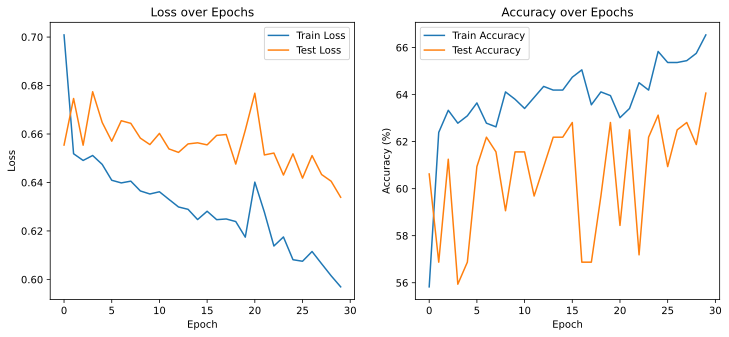

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class WineNet(nn.Module):
    def __init__(self, input_dim):
        super(WineNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)  # binary output

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)  # logits

# Assume train_loader and test_loader are ready
input_dim = next(iter(train_loader))[0].shape[1]
model = WineNet(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossfun = nn.BCEWithLogitsLoss()

num_epochs = 30
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = lossfun(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
        
    train_losses.append(train_loss / total)
    train_accuracies.append(100 * correct / total)

    # Evaluate on test set
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = lossfun(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    test_losses.append(test_loss / total)
    test_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}% | Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

# Plot losses and accuracies
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()
